## Nessa primeira etapa iremos normalizar os dados

* Extrair informações da planilha em um unico dataframe
* Tratamento de ncm    
    * preencher com zeros a esquerda ncm menores de 8
    * excluir produtos sem ncm
    * excluir ncm vencido ou inválidos (proxima etapa)
* Tratamento na descrição 
    * transformar palavras em caixa alta
    * remoção de acentos
    * remoção de espaços duplos

### Extrair informações da planilha em um unico dataframe

In [1]:
#O módulo 'xlrd' é necessário para ler arquivos do Excel no pandas.
#!pip install xlrd
#!pip install update nltk

In [2]:
#bibliotecas

import os
import pandas as pd
import requests

# Importar biblioteca de regex
import re

# Importar biblioteca nltk para remoção de stop words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Biblioteca para remoção de caracteres especiais
from unicodedata import normalize
from string import punctuation

In [3]:
colunas = ['Código NCM', 'Descrição']
df_sintetico = pd.DataFrame(columns=colunas)
df_sintetico = pd.read_excel(r'dados iniciais.xlsx', dtype={'Código NCM': str})

#visualizando
df_sintetico

,Código NCM,Descrição
0,21069090,"35 RECH FORN MARACUJAR 1,01KG PRINCIPIO"
1,21069090,"35 RECH FORN COCO CREMOSO 1,01KG PRINCIPIO"
2,08044000,ABACATE
3,08044000,ABACATE AVOCADO KG
4,08043000,ABACAXI PC
...,...,...
541033,NaN,VASO PRETO TRAPLAST N 0
541034,NaN,VASO PRETO TRAPLAST N 01
541035,NaN,KIT BRINQ COZINHA CESTINHO 66
541036,NaN,REFR. VERT. VN50C (TERCEIROS)


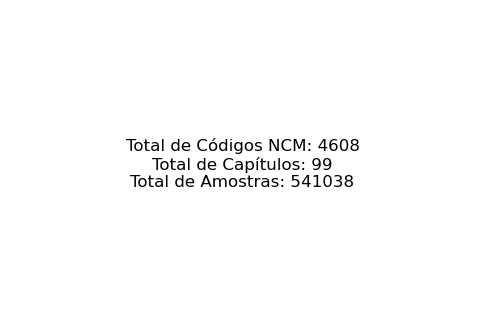

Total de Códigos NCM: 4608
Total de Capítulos: 99
Total de Amostras: 541038


In [4]:
import matplotlib.pyplot as plt

# Calcular o total de códigos NCM por grupo
df_groups = df_sintetico['Código NCM'].astype(str).apply(lambda x: x[:2]).groupby(df_sintetico['Código NCM']).count()
total_ncm = df_groups.shape[0]  # Total de códigos NCM

# Calcular o total de capítulos
total_capitulos = df_sintetico['Código NCM'].astype(str).apply(lambda x: x[:2]).nunique()  # Total de capítulos

# Calcular o total geral de amostras
total_amostras = df_sintetico.shape[0]  # Total geral de amostras

# Exibir os resultados em um "card"
plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, f"Total de Códigos NCM: {total_ncm}\nTotal de Capítulos: {total_capitulos}\nTotal de Amostras: {total_amostras}",
         fontsize=12, ha='center', va='center')
plt.axis('off')  # Remover os eixos do gráfico
plt.show()

# Exibir os valores com print
print(f"Total de Códigos NCM: {total_ncm}")
print(f"Total de Capítulos: {total_capitulos}")
print(f"Total de Amostras: {total_amostras}")


### Tratamento de ncm

In [5]:
#remoção de todos os NCMs invalidos

# Fazer a requisição HTTP para obter o JSON dos NCMs
url = 'https://portalunico.siscomex.gov.br/classif/api/publico/nomenclatura/download/json'
response = requests.get(url)

# Verificar se a requisição foi bem-sucedida (código de status 200)
if response.status_code == 200:
    # Carregar o JSON em um pandas DataFrame
    json_data = response.json()
    ncms = []
    for nomenclatura in json_data['Nomenclaturas']:
        codigo = nomenclatura['Codigo'].replace('.', '')
        if len(codigo) == 8:
            ncms.append(codigo)
    
    # Filtrar os NCMs presentes no seu DataFrame df_sintetico
    ncms_validos = df_sintetico['Código NCM'].isin(ncms)
    df_sintetico = df_sintetico[ncms_validos]    

else:
    print('Falha ao obter o JSON dos NCMs.')

In [6]:
#removendo NCM com muitos itens incorretos (analisado pós processamento)

df_sintetico = df_sintetico[df_sintetico['Código NCM'] != '41079990']

In [7]:
df_sintetico.shape
df_sintetico

,Código NCM,Descrição
0,21069090,"35 RECH FORN MARACUJAR 1,01KG PRINCIPIO"
1,21069090,"35 RECH FORN COCO CREMOSO 1,01KG PRINCIPIO"
2,08044000,ABACATE
3,08044000,ABACATE AVOCADO KG
4,08043000,ABACAXI PC
...,...,...
540850,96190000,ROUPA INTIMA PLENITUDE FEMME G
540851,96190000,FRALDA DESC GERIAT PLENITUDE PROTECT PLUS G/XG...
540852,96190000,FRALDA DESC TURMA DA MONICA BABY XXG 36UN
540853,96190000,FRALDA DESCARTAVEL POM POM XG 20UN


### Tratamento de descricao

In [8]:
#faz o download de recursos necessários para a tokenização de texto
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SAAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
def remover_sw(texto):
    sentenca_limpa = ''
    
    #tokerizando
    tokens = word_tokenize(texto)  
    
    #não estou fazendo stemming nesse momento
    # Fazendo stemming em cada token
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in tokens]
    
    #juntando palavras novamente ??
    sentenca_limpa = [w for w in stems if not w.lower() in stop_words]
    return ' '.join(sentenca_limpa)


def limpar_texto(texto):
    # Tratando caracteres especiais
    texto = normalize('NFKD', texto). encode('ASCII', 'ignore').decode('ASCII')
    # Removendo pontuações
    texto = re.sub(f'[{punctuation}]', '', texto)
    # Removendo número
    texto = re.sub('[0-9]', '', texto)
    # Colocar em caixa baixa
    texto = texto.lower()
    # Removendo stop words
    texto = remover_sw(texto)

    return texto

In [10]:
#limpeza caracteres especiais, pontuação, lower e remoção de stop words e descrições vazias
#%%time
df_sintetico.loc[:, 'Descrição'] = df_sintetico['Descrição'].fillna('').map(limpar_texto)
df_sintetico.dropna(subset=['Descrição'], inplace=True)


In [11]:
#remoção de produtos duplicados
#df_sintetico = df_sintetico.drop_duplicates()

### Exportando dados

In [12]:
# exportar planilha para facilitar na hora da analise
df_sintetico.to_excel('dados_tratados_ncm_e_descricao.xlsx', index=False, header=True)

#df_sintetico[['Código NCM', 'Descrição']].to_csv('dados_tratados_ncm_e_descricao.csv', index=False)